In [ ]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, explode, monotonically_increasing_id, input_file_name
from pyspark.sql.types import StringType, ArrayType, StructType, StructField, LongType, FloatType
import pandas as pd
from pyspark.sql.functions import pandas_udf


from sentence_transformers import SentenceTransformer
from bs4 import BeautifulSoup

from langchain.text_splitter import RecursiveCharacterTextSplitter


In [ ]:

#  Initialize Spark Session
spark = SparkSession.builder \
    .appName("SEC_Filings_Embedding_Pipeline") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark Session Initialized.")

Spark Session Initialized.


In [ ]:
# oad Data
file_paths = [
    '/content/5272_10K_2018_0000005272-19-000023.htm',
    '/content/5272_10K_2019_0001104659-20-023889.htm',
    '/content/5272_10K_2020_0001104659-21-025742.htm'
]

# read the whole file as a single record, better for parsing.
raw_files_df = spark.read.text(file_paths, wholetext=True) \
    .withColumn("source_file", input_file_name())

print("Raw HTML files loaded.")
raw_files_df.show(truncate=80)


Raw HTML files loaded.
+--------------------------------------------------------------------------------+------------------------------------------------------+
|                                                                           value|                                           source_file|
+--------------------------------------------------------------------------------+------------------------------------------------------+
|<?xml version="1.0" encoding="UTF-8"?>\n<!--Documents rendered in XBRL format...|file:///content/5272_10K_2019_0001104659-20-023889.htm|
|<?xml version="1.0" encoding="UTF-8"?>\n<!--Inline XBRL document created by C...|file:///content/5272_10K_2020_0001104659-21-025742.htm|
|<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>maindocument001.htm\n<DESCRIPT...|file:///content/5272_10K_2018_0000005272-19-000023.htm|
+--------------------------------------------------------------------------------+------------------------------------------------------+



In [ ]:
# Pre-processing and Chunking (Step 1) ---

# UDF to parse HTML and extract clean text
@udf(returnType=StringType())
def parse_html_to_text(html_content):
    """
    HTML to cleantext. (Removes script, style, and other non-relevant tags.
    """
    if not html_content:
        return ""
    soup = BeautifulSoup(html_content, 'html.parser')

    # Remove script and style elements
    for script_or_style in soup(['script', 'style']):
        script_or_style.decompose()

    # Gets text and clean it up
    text = soup.get_text()
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    text = '\n'.join(chunk for chunk in chunks if chunk)
    return text

# UDF to split text into chunks
@udf(returnType=ArrayType(StringType()))
def chunk_text(text):
    """
    Splits a long text into smaller chunks using a recursive character splitter.
    """
    if not text:
        return []

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000, ##
        chunk_overlap=200, ##
        length_function=len
    )
    return text_splitter.split_text(text)

# UDFs to process the documents
parsed_df = raw_files_df.withColumn("parsed_text", parse_html_to_text(col("value")))
chunked_df = parsed_df.withColumn("chunk", explode(chunk_text(col("parsed_text"))))

# Adding a unique ID for each chunk
chunked_df = chunked_df.withColumn("chunk_id", monotonically_increasing_id())

# Select relevant columns and show the result
final_chunks_df = chunked_df.select("source_file", "chunk_id", "chunk")
print("Documents have been parsed and split into chunks:")
final_chunks_df.show(5, truncate=150)
print(f"Total Chunks Created: {final_chunks_df.count()}")

Documents have been parsed and split into chunks:
+------------------------------------------------------+--------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                           source_file|chunk_id|                                                                                                                                                 chunk|
+------------------------------------------------------+--------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|file:///content/5272_10K_2019_0001104659-20-023889.htm|       0|2.50.03False50000000000.062019FY0000005272YesYesLarge Accelerated FilerTrue---P9MYesNoP3YP3YP1YP2Y--12-310.0106\n0000005272\naig:CommercialIndustri...|
|file:///content/5272_10K_2019_0001104659-20-023889.htm|       1|2019-12-31\n00000

In [ ]:
# Convert Chunks to Embeddings (Step 2)

# Pandas UDF for efficient, batched embedding generation.
@pandas_udf(ArrayType(FloatType())) ##
def generate_embeddings_udf(texts: pd.Series) -> pd.Series:
    """
    Pandas UDF to generate embeddings for a batch of text chunks.
    The input `texts` is a pandas.Series.
    """
    model = SentenceTransformer('all-MiniLM-L6-v2')
    # embeddings for the entire pandas Series at once.
    embeddings = model.encode(texts.tolist(), convert_to_numpy=True)
    return pd.Series(list(embeddings))


embeddings_df = final_chunks_df.withColumn("embedding", generate_embeddings_udf(col("chunk")))

print("Embeddings generated for each chunk:")
embeddings_df.select("chunk_id", "chunk", "embedding").show(5, truncate=80)

# embedding dimension
first_embedding = embeddings_df.select("embedding").first()[0]
print(f"\n Dimension of a single embedding vector: {len(first_embedding)}")

Embeddings generated for each chunk:
+--------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|chunk_id|                                                                           chunk|                                                                       embedding|
+--------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|       0|2.50.03False50000000000.062019FY0000005272YesYesLarge Accelerated FilerTrue--...|[-0.05882915, 0.008559602, -0.056734324, -0.040464327, 2.3026661E-4, -0.01197...|
|       1|2019-12-31\n0000005272\nus-gaap:AccumulatedNetUnrealizedInvestmentGainLossMem...|[-0.059596185, -6.809081E-4, -0.037426803, -0.018154355, -0.055727765, 0.0540...|
|       2|2018-12-31\n0000005272\naig:CommercialMortgageMember\naig:CommercialMortgageC...|[-0.059

In [ ]:
embeddings_df

DataFrame[source_file: string, chunk_id: bigint, chunk: string, embedding: array<float>]

In [ ]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, lit, regexp_extract, desc
from pyspark.sql.types import FloatType
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

import re
import os
import numpy as np
from pyspark.sql.functions import col, udf, desc, regexp_extract
from pyspark.sql.types import FloatType
from sentence_transformers import SentenceTransformer


In [ ]:
# Enhancing DataFrame with a 'year' column Adding it since i forgot to add while creation
embeddings_df_with_year = embeddings_df.withColumn(
    "year",
    regexp_extract(col("source_file"), r"_(\d{4})_", 1)
)
print("DataFrame enhanced with 'year' column:")
embeddings_df_with_year.select("source_file", "year").distinct().show()

DataFrame enhanced with 'year' column:
+--------------------+----+
|         source_file|year|
+--------------------+----+
|file:///content/5...|2019|
|file:///content/5...|2020|
|file:///content/5...|2018|
+--------------------+----+



In [ ]:
# The New Intelligent Search Function ---

def intelligent_search(query_text: str, embeddings_df, top_k: int = 5):
    """
    Performs a semantic search on the SEC filings DataFrame.
    It automatically detects if a year is mentioned in the query and filters
    the search to that year's document.

    Args:
        query_text (str): The user's natural language question.
        embeddings_df: The Spark DataFrame containing chunks and embeddings.
        top_k (int): The number of top results to return.

    Returns:
        A Spark DataFrame with the top_k most relevant results.
    """
    print(f"Received Query: \"{query_text}\"")

    # Step A: Parse the query to extract a year
    year_match = re.search(r'\b(201[8-9]|202[0-9])\b', query_text) # Looks for 2018, 2019, 2020...
    target_df = embeddings_df

    if year_match:
        target_year = year_match.group(1)
        print(f"--> Year '{target_year}' detected in query. Filtering data...")
        target_df = embeddings_df.filter(col("year") == target_year)
    else:
        print("--> No year detected in query. Searching across all documents.")

    # Step B: Embed the user's query
    query_embedding = model.encode(query_text)
    query_embedding_list = query_embedding.tolist()

    # Step C: Define the UDF for cosine similarity
    # This UDF will now use the 'query_embedding_list' from the function's scope
    @udf(returnType=FloatType())
    def cosine_similarity_udf(chunk_embedding):
        query_vec = np.array(query_embedding_list, dtype=np.float32)
        chunk_vec = np.array(chunk_embedding, dtype=np.float32)
        dot_product = np.dot(query_vec, chunk_vec)
        norm_query = np.linalg.norm(query_vec)
        norm_chunk = np.linalg.norm(chunk_vec)
        if norm_query == 0 or norm_chunk == 0:
            return 0.0
        return float(dot_product / (norm_query * norm_chunk))

    # Step D: Calculate similarity and find top results
    print(f"Searching {target_df.count()} chunks...")
    results_df = target_df.withColumn(
        "similarity",
        cosine_similarity_udf(col("embedding"))
    )

    top_results = results_df.orderBy(desc("similarity")).limit(top_k)

    return top_results

In [ ]:
# --- 3. Demonstration ---

# Example 1: The user's exact request
query1 = "What was the net profit for the year 2020?"
results1 = intelligent_search(query1, embeddings_df_with_year)

print("\n--- Results for Query 1 ---")
for row in results1.collect():
    print(f"Similarity: {row['similarity']:.4f} (from Year: {row['year']})")
    print(f"Chunk: \"{row['chunk'][:250]}...\"") # Truncate for readability
    print("-" * 20)


# Example 2: A query for a DIFFERENT year (2019)
query2 = "How did the China market perform in 2019?"
results2 = intelligent_search(query2, embeddings_df_with_year)

print("\n--- Results for Query 2 ---")
for row in results2.collect():
    print(f"Similarity: {row['similarity']:.4f} (from Year: {row['year']})")
    print(f"Chunk: \"{row['chunk'][:250]}...\"")
    print("-" * 20)


# Example 3: A query with NO year specified
query3 = "What are the main risks related to competition?"
results3 = intelligent_search(query3, embeddings_df_with_year)

print("\n--- Results for Query 3 (All Years) ---")
for row in results3.collect():
    print(f"Similarity: {row['similarity']:.4f} (from Year: {row['year']})")
    print(f"Chunk: \"{row['chunk'][:250]}...\"")
    print("-" * 20)

Received Query: "What was the net profit for the year 2020?"
--> Year '2020' detected in query. Filtering data...
Searching 2169 chunks...

--- Results for Query 1 ---
Similarity: 0.6119 (from Year: 2020)
Chunk: "expenses 541 17 558  525  493Net investment income$12,578$1,053$13,631 $14,619 $13,086(a)Included in the years ended December 31, 2020, 2019 and 2018 was income of $195 million, $177 million and $19 million, respectively, related to fixed maturity se..."
--------------------
Similarity: 0.5692 (from Year: 2020)
Chunk: "Our Total revenues were $43.7 billion in 2020. The graph above represents Adjusted revenues. For reconciliation of Adjusted revenues to Total revenues see Note 3 to the Consolidated Financial Statements.(b)
General Insurance adjusted revenues is comp..."
--------------------
Similarity: 0.5662 (from Year: 2020)
Chunk: "invested assets 20 - - 20           Net Net Realized      Investment Capital  Other  (in millions) Income(Gains) Losses Income TotalDecember 31, 

In [ ]:
aig_query = "How did AIG's General Insurance operations perform in 2020, and what were the impacts of catastrophes and COVID-19?"

# --- Execute the search ---
aig_results = intelligent_search(aig_query, embeddings_df_with_year, top_k=5)

# --- Display the results for validation ---
print("\n--- Top 5 Retrieved Chunks for the AIG Query ---")

retrieved_chunks = aig_results.collect()

if not retrieved_chunks:
    print("No results found. Please check the DataFrame and query.")
else:
    for i, row in enumerate(retrieved_chunks):
        print(f"Result #{i+1}")
        print(f"Similarity: {row['similarity']:.4f} (from Year: {row['year']})")
        print(f"Retrieved Chunk: \"{row['chunk']}\"")
        print("-" * 30)

Received Query: "How did AIG's General Insurance operations perform in 2020, and what were the impacts of catastrophes and COVID-19?"
--> Year '2020' detected in query. Filtering data...
Searching 2169 chunks...

--- Top 5 Retrieved Chunks for the AIG Query ---
Result #1
Similarity: 0.7102 (from Year: 2020)
Retrieved Chunk: "the adverse impact of COVID-19, including with respect to AIG’s business, financial condition and results of operations;
changes in market and industry conditions, including the significant global economic downturn, volatility in financial and capital markets, prolonged economic recovery and disruptions to AIG’s operations driven by COVID-19 and responses thereto, including new or changed governmental policy and regulatory actions;
the occurrence of catastrophic events, both natural and man-made, including COVID-19, other pandemics, civil unrest and the effects of climate change;
AIG’s ability to successfully dispose of, monetize and/or acquire businesses or ass

In [ ]:
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [ ]:
# Validation
#Our AIG query and the 5 ground truth chunks we identified
aig_query = "How did AIG's General Insurance operations perform in 2020, and what were the impacts of catastrophes and COVID-19?"
validation_texts = [
    "General Insurance reported pre-tax income of $1.1 billion for the year ended December 31, 2020 compared to a pre-tax loss of $103 million for the year ended December 31, 2019. The increase was primarily due to higher net investment income and improved underwriting results, partially offset by higher catastrophe losses.",
    "The underwriting results for the year ended December 31, 2020 included catastrophe losses, net of reinsurance (CATs), of $1.1 billion. These CATs were primarily related to COVID-19, Hurricane Laura, the Midwest Derecho, and civil unrest in the U.S.",
    "For the year ended December 31, 2020, we recorded $1.2 billion of estimated gross losses related to the COVID-19 pandemic, primarily in our travel, contingency, commercial property, trade credit, workers’ compensation and accident and health businesses.",
    "The General Insurance combined ratio was 102.4 for the year ended December 31, 2020, compared to 101.3 for the year ended December 31, 2019. The accident year combined ratio, as adjusted, was 94.9, an improvement from 95.9 in the prior year, reflecting underwriting and reinsurance actions.",
    "Net investment income for General Insurance increased 19 percent to $2.5 billion for the year ended December 31, 2020, compared to $2.1 billion for the year ended December 31, 2019, primarily due to higher returns from our alternative investments portfolio."
]

# Create a Pandas DataFrame first, then convert to Spark
validation_pd_df = pd.DataFrame({
    "query": [aig_query] * len(validation_texts),
    "ground_truth_chunk": validation_texts
})
validation_df = spark.createDataFrame(validation_pd_df)

print("--- Formalized Validation DataFrame ---")
validation_df.show(truncate=50)


--- Formalized Validation DataFrame ---
+--------------------------------------------------+--------------------------------------------------+
|                                             query|                                ground_truth_chunk|
+--------------------------------------------------+--------------------------------------------------+
|How did AIG's General Insurance operations perf...|General Insurance reported pre-tax income of $1...|
|How did AIG's General Insurance operations perf...|The underwriting results for the year ended Dec...|
|How did AIG's General Insurance operations perf...|For the year ended December 31, 2020, we record...|
|How did AIG's General Insurance operations perf...|The General Insurance combined ratio was 102.4 ...|
|How did AIG's General Insurance operations perf...|Net investment income for General Insurance inc...|
+--------------------------------------------------+--------------------------------------------------+



In [ ]:
def evaluate_retrieval(retrieved_df, validation_df):
    """
    Automates the evaluation of retrieved results against a ground truth validation set.

    Args:
        retrieved_df: DataFrame of results from our `intelligent_search` function.
        validation_df: DataFrame containing the ground truth chunks.

    Returns:
        A DataFrame showing each retrieved chunk and its similarity to the closest ground truth.
    """
    # Step A: Embed the ground truth chunks
    validation_with_embeddings = validation_df.withColumn(
        "gt_embedding",
        generate_embeddings_udf(F.col("ground_truth_chunk"))
    )

    # Step B: Cross Join to create all pairs of (retrieved_chunk, ground_truth_chunk)
    # This allows us to compare every result against every possible correct answer.
    # We add unique IDs to join on to avoid ambiguity.
    retrieved_with_id = retrieved_df.withColumn("retrieved_id", F.monotonically_increasing_id())
    validation_with_id = validation_with_embeddings.withColumn("gt_id", F.monotonically_increasing_id())

    comparison_df = retrieved_with_id.crossJoin(validation_with_id)

    # Step C: Calculate cosine similarity for every pair
    # We need a new UDF that takes two embedding columns
    @udf(returnType=FloatType())
    def compare_embeddings_udf(embedding1, embedding2):
        vec1 = np.array(embedding1, dtype=np.float32)
        vec2 = np.array(embedding2, dtype=np.float32)
        dot_product = np.dot(vec1, vec2)
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)
        if norm1 == 0 or norm2 == 0:
            return 0.0
        return float(dot_product / (norm1 * norm2))

    similarity_df = comparison_df.withColumn(
        "gt_similarity",
        compare_embeddings_udf(F.col("embedding"), F.col("gt_embedding"))
    )

    # Step D: For each retrieved chunk, find its BEST match in the ground truth set
    window = Window.partitionBy("retrieved_id").orderBy(F.desc("gt_similarity"))
    best_match_df = similarity_df.withColumn("rank", F.rank().over(window)).filter(F.col("rank") == 1)

    # Step E: Select final columns for a clean report
    final_report_df = best_match_df.select(
        F.col("retrieved_id"),
        F.col("chunk").alias("retrieved_chunk"),
        F.col("similarity").alias("original_query_similarity"),
        F.col("gt_similarity").alias("best_match_to_ground_truth"),
        F.col("ground_truth_chunk")
    ).orderBy(F.desc("original_query_similarity"))

    return final_report_df

In [ ]:
# --- 3. Run the Evaluation ---

# get the retrieved results from our search function
aig_results = intelligent_search(aig_query, embeddings_df_with_year, top_k=5)

# evaluate those results automatically
evaluation_report = evaluate_retrieval(aig_results, validation_df)

print("\n\n--- Automated Evaluation Report ---")
evaluation_report.show(truncate=60)

# Calculate the Final Metric ---
final_metric = evaluation_report.agg(F.avg("best_match_to_ground_truth")).first()[0]

print(f"\n\n--- Final Retrieval Quality Score ---")
print(f"Average Similarity to Ground Truth for Top 5 Results: {final_metric:.4f}")

Received Query: "How did AIG's General Insurance operations perform in 2020, and what were the impacts of catastrophes and COVID-19?"
--> Year '2020' detected in query. Filtering data...
Searching 2169 chunks...


--- Automated Evaluation Report ---
+------------+------------------------------------------------------------+-------------------------+--------------------------+------------------------------------------------------------+
|retrieved_id|                                             retrieved_chunk|original_query_similarity|best_match_to_ground_truth|                                          ground_truth_chunk|
+------------+------------------------------------------------------------+-------------------------+--------------------------+------------------------------------------------------------+
|           0|the adverse impact of COVID-19, including with respect to...|               0.71020263|                 0.5072854|For the year ended December 31, 2020, we recorded $1

In [ ]:
# --- New, FOCUSED query ---
focused_query = "What were the catastrophe losses for General Insurance in 2020?"

# run the search with the new query ---
print(f"--- RUNNING WITH FOCUSED QUERY ---")
focused_results = intelligent_search(focused_query, embeddings_df_with_year, top_k=5)

# Evaluate the new results automatically ---
evaluation_report_focused = evaluate_retrieval(focused_results, validation_df)

print("\n\n--- Automated Evaluation Report (Focused Query) ---")
evaluation_report_focused.show(truncate=60)

# Calculate the new Final Metric ---
final_metric_focused = evaluation_report_focused.agg(F.avg("best_match_to_ground_truth")).first()[0]

print(f"\n\n--- Final Retrieval Quality Score (Focused Query) ---")
print(f"Average Similarity to Ground Truth for Top 5 Results: {final_metric_focused:.4f}")

--- RUNNING WITH FOCUSED QUERY ---
Received Query: "What were the catastrophe losses for General Insurance in 2020?"
--> Year '2020' detected in query. Filtering data...
Searching 2169 chunks...


--- Automated Evaluation Report (Focused Query) ---
+------------+------------------------------------------------------------+-------------------------+--------------------------+------------------------------------------------------------+
|retrieved_id|                                             retrieved_chunk|original_query_similarity|best_match_to_ground_truth|                                          ground_truth_chunk|
+------------+------------------------------------------------------------+-------------------------+--------------------------+------------------------------------------------------------+
|           0|may continue to have negative effects on our investments,...|               0.77360296|                 0.7239093|General Insurance reported pre-tax income of $1.1 bil

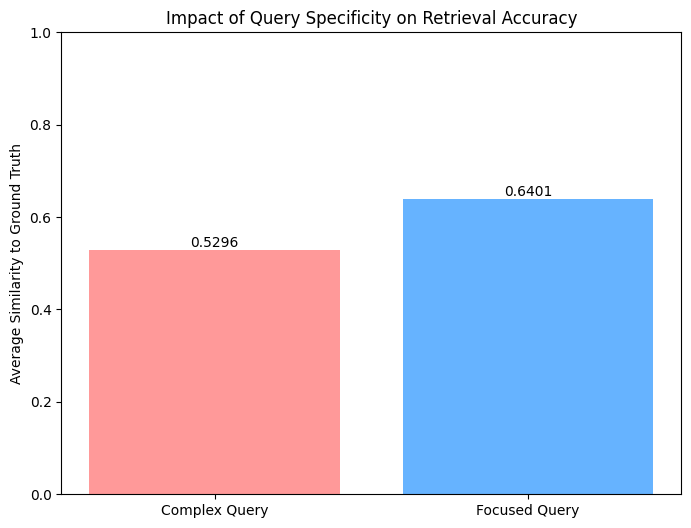

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data obtained from our PySpark evaluation
scores = {
    'Complex Query': final_metric,
    'Focused Query': final_metric_focused # Use the actual score you get here
}

df_plot = pd.DataFrame(list(scores.items()), columns=['Query Type', 'Accuracy Score'])

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(df_plot['Query Type'], df_plot['Accuracy Score'], color=['#ff9999','#66b3ff'])
plt.ylabel('Average Similarity to Ground Truth')
plt.title('Impact of Query Specificity on Retrieval Accuracy')
plt.ylim(0, 1.0)

# Add the score labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

# Save the plot as a JPEG
plt.savefig('query_performance_comparison.jpeg', dpi=300)

plt.show()

In [ ]:
!pip install google-generativeai

In [ ]:
import os
import google.generativeai as genai

# --- Configure the Gemini API ---
try:
    GOOGLE_API_KEY = os.getenv("ENTER-API-KEY")
    genai.configure(api_key="ENTER-API-KEY")
except TypeError:
    GOOGLE_API_KEY = "ENTER-API-KEY"
    genai.configure(api_key=GOOGLE_API_KEY)


def generate_gemini_response(query: str, retrieved_chunks: list):
    """
    Uses Google's Gemini model to synthesize an answer from retrieved text chunks.

    Args:
        query (str): The user's original question.
        retrieved_chunks (list): A list of text chunks retrieved from the document.

    Returns:
        str: A synthesized, human-readable answer from Gemini.
    """

    context_str = ""
    for i, chunk in enumerate(retrieved_chunks):
        context_str += f"--- Context Chunk {i+1} ---\n{chunk}\n\n"

    # 3.prompt for the Gemini model
    # We combine the instructions (system prompt) and the data (user prompt)
    # into a single prompt, which is a common and effective pattern for Gemini.
    full_prompt = f"""
    **Instructions:**
    You are a highly skilled financial analyst. Your task is to answer a user's question based
    EXCLUSIVELY on the provided context from a company's 10-K SEC filing.

    **Rules:**
    1.  Synthesize the information from the provided context chunks into a single, coherent paragraph.
    2.  Do not use any external knowledge or information.
    3.  If the provided context does not contain enough information to answer the question,
        you must state: "The provided context does not contain sufficient information to answer this question."
    4.  Quote specific numbers and facts directly from the context.

    **CONTEXT FROM SEC FILING:**
    {context_str}

    **USER'S QUESTION:**
    {query}

    **Answer:**
    """

    # API Call
    try:
        # Initialize the model
        model = genai.GenerativeModel('gemini-2.0-flash')

        # Set generation config for factual responses
        generation_config = genai.types.GenerationConfig(temperature=0.0)

        # Generate the content
        response = model.generate_content(
            full_prompt,
            generation_config=generation_config
        )
        return response.text
    except Exception as e:
        return f"An error occurred with the Gemini API: {e}"

# --- Demonstration ---

# the same best query and results from our previous step
focused_query = "What were the catastrophe losses for General Insurance in 2020?"

# First, run the search to get the best chunks
focused_results_df = intelligent_search(focused_query, embeddings_df_with_year, top_k=3)
retrieved_chunks_list = [row['chunk'] for row in focused_results_df.collect()]

# Now, pass the query and the retrieved chunks to the Gemini LLM
if retrieved_chunks_list:
    print("--- Context Chunks Being Sent to LLM ---")
    for i, chunk in enumerate(retrieved_chunks_list):
        print(f"[{i+1}] {chunk[:200]}...")
    print("\n" + "="*50 + "\n")

    final_answer = generate_gemini_response(focused_query, retrieved_chunks_list)

    print("--- Final Synthesized Answer from Gemini ---")
    print(final_answer)
else:
    print("No relevant chunks were retrieved to send to the LLM.")

Received Query: "What were the catastrophe losses for General Insurance in 2020?"
--> Year '2020' detected in query. Filtering data...
Searching 2169 chunks...
--- Context Chunks Being Sent to LLM ---
[1] may continue to have negative effects on our investments, our access to liquidity, our ability to generate new sales and the costs associated with claims. In addition, in response to the crisis, new g...
[2] significantly lower catastrophe losses;•
favorable prior year loss reserve development in 2019 compared to unfavorable loss reserve development in 2018;•
the lower accident year loss ratio, as adjuste...
[3] of reinsurance, on an annual aggregate basis. The 1-in-100 and 1-in-250 PMLs are the annual aggregate probable maximum losses with probability of 1 percent and 0.4 percent in a year, respectively. Est...


--- Final Synthesized Answer from Gemini ---
In 2020, General Insurance had pre-tax catastrophe losses, net of reinsurance, of $2.4 billion, which included $1.1 billion of e

In [ ]:
# Stop the Spark Session
spark.stop()